# Anthropogenic heat from buildings

This notebook is used to process building energy use, analyze data, and ultimately produce the anthropogenic heat flux (AHF) from buildings for the Greater Los Angeles (LA) region.

In [1]:
# load necessary packages 
%matplotlib inline
import os
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib
#import requests
import geopandas

## Import data from data repositories

Download Energy Atlas data from Kaggle repo (if not already in local directory)

In [2]:
energy_atlas_data_path = Path('data/energy_atlas')
if not os.path.isdir(energy_atlas_data_path): # if data directory does not exist (i.e., data not downloaded yet)
    # initialize kaggle API
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()

    # download from my Kaggle dataset page
    dataset = 'josephko/la-energy-atlas-2016'
    download_path = Path('data/energy_atlas')
    api.dataset_download_files(dataset, download_path) # downloads all data in zip file
    
    # unzip and remove zip file
    zip_file = download_path / 'la-energy-atlas-2016.zip'
    with zipfile.ZipFile(zip_file) as file:
        file.extractall(download_path)
    os.remove(zip_file)


Import Energy Atlas data into dataframes

In [3]:
usage_file = energy_atlas_data_path / 'usage_bld_btu.csv'
usage_bld_btu = pd.read_csv(usage_file, na_values = ['NaN'])
print(usage_bld_btu._is_copy)
usage_bld_btu = usage_bld_btu.loc[usage_bld_btu['usage'] != 'masked'].copy()
print(usage_bld_btu._is_copy)

# # TESTING 
# cols = usage_bld_btu.columns.drop(['geo_id', 'usetype', 'name'])
# usage_bld_btu.loc[:,cols] = usage_bld_btu.loc[:, cols].apply(pd.to_numeric, errors = 'coerce')

usage_bld_btu

None
None


,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
1,cities_1,4820002.0,307943899305.5130,552251718.742479,46351.2600,commercial,2016,0.729374077813779,0.27062592218622,agoura hills,NaN,NaN
2,cities_1,8916603.0,371532651324.6650,75308184.502491,34141.0256,condo,2016,0.401411831210031,0.598588168789969,agoura hills,NaN,NaN
5,cities_1,742420.0,13880934410.2757,551195246.006691,27645.8101,multi_family,2016,0.494247031872507,0.505752968127493,agoura hills,NaN,NaN
9,cities_1,14582828.0,607423395220.2180,77423013.203888,34664.6960,res_total,2016,0.39367841860114,0.606321581398859,agoura hills,20236.0,30016969.5207
10,cities_1,4871778.0,185856698385.1830,81616936.012045,36044.4204,single_family,2016,0.404338301428263,0.595661698571739,agoura hills,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5762,neighborhoods_99,NaN,NaN,NaN,NaN,condo,2016,NaN,NaN,carthay,NaN,NaN
5765,neighborhoods_99,1896313.0,62287216523.5229,123951796.951531,33829.0805,multi_family,2016,0.315242860698158,0.684757139301843,carthay,NaN,NaN
5769,neighborhoods_99,3452091.0,135011350072.0880,92115112.9332543,35663.1742,res_total,2016,0.325581077358624,0.674418922641377,carthay,5201.0,25958729.1044
5770,neighborhoods_99,1525718.0,61785646186.9359,79130635.2189765,37415.2632,single_family,2016,0.352719384793062,0.647280615206937,carthay,NaN,NaN


## Download LA Times Mapping neighborhoods data

In [9]:
url = 'https://github.com/datadesk/mapping-la-data/raw/main/geojson/la-county-neighborhoods-v6.geojson'
#file = requests.get(url)
neighborhoods = geopandas.read_file(url)
neighborhoods.head()

,kind,external_id,name,slug,set,metadata,resource_uri,geometry
0,L.A. County Neighborhood (V6),acton,Acton,acton-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': '', 'name': 'Acton', 'region': 'antel...",/1.0/boundary/acton-la-county-neighborhood-v6/,"MULTIPOLYGON (((-118.20703 34.53902, -118.1894..."
1,L.A. County Neighborhood (V6),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': 'los-angeles', 'name': 'Adams-Normand...",/1.0/boundary/adams-normandie-la-county-neighb...,"MULTIPOLYGON (((-118.30800 34.03740, -118.3006..."
2,L.A. County Neighborhood (V6),agoura-hills,Agoura Hills,agoura-hills-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': '', 'name': 'Agoura Hills', 'region':...",/1.0/boundary/agoura-hills-la-county-neighborh...,"MULTIPOLYGON (((-118.77621 34.16816, -118.7263..."
3,L.A. County Neighborhood (V6),agua-dulce,Agua Dulce,agua-dulce-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': '', 'name': 'Agua Dulce', 'region': '...",/1.0/boundary/agua-dulce-la-county-neighborhoo...,"MULTIPOLYGON (((-118.37822 34.48811, -118.3783..."
4,L.A. County Neighborhood (V6),alhambra,Alhambra,alhambra-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': '', 'name': 'Alhambra', 'region': 'sa...",/1.0/boundary/alhambra-la-county-neighborhood-v6/,"MULTIPOLYGON (((-118.12175 34.10504, -118.1168..."


<AxesSubplot:>

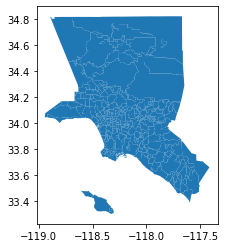

In [10]:
# plot boundaries of neighborhoods for visual check
neighborhoods.plot()

## Descriptive analysis of Energy Atlas data

In [ ]:
# How many different usetype categories?
usage_bld_btu['usetype'].unique()

In [ ]:
# subset only neighborhood-aggregated records
usage_bld_btu_neighborhoods = usage_bld_btu.loc[usage_bld_btu['geo_id'].str.contains('neighborhoods')].copy()
usage_bld_btu_neighborhoods

In [ ]:
# How many unique neighborhoods?
len(usage_bld_btu_neighborhoods['geo_id'].unique())

In [ ]:
# further subset for only residential
usage_bld_btu_neighborhoods_res = usage_bld_btu_neighborhoods.loc[usage_bld_btu_neighborhoods['usetype'] == 'res_total'].copy()
usage_bld_btu_neighborhoods_res

In [ ]:
print(usage_bld_btu_neighborhoods_res._is_copy)

In [ ]:
# testing SettingWithCopyWarning with test df
df = pd.DataFrame({'A': ['1', '2', 'NaN'], 'B': ['1', 'NaN', '3'], 'C': ['1', '2', '3']})
cols = df.columns.drop(['C'])
df.loc[:, cols] = df[cols].apply(pd.to_numeric, errors = 'coerce')
df

In [ ]:
# convert appropriate columns to numeric
cols = usage_bld_btu_neighborhoods_res.columns.drop(['geo_id', 'usetype', 'name'])
usage_bld_btu_neighborhoods_res.loc[:,cols] = usage_bld_btu_neighborhoods_res[cols].apply(pd.to_numeric, errors = 'coerce')
usage_bld_btu_neighborhoods_res.dtypes

In [ ]:
# distribution of pct_elec
usage_bld_btu_neighborhoods_res['pct_elec'] = pd.to_numeric(usage_bld_btu_neighborhoods_res['pct_elec'])
usage_bld_btu_neighborhoods_res['pct_elec'].plot.hist(bins = 20) 